# Autoencoding

Adapated from [this tutorial](https://stackabuse.com/autoencoders-for-image-reconstruction-in-python-and-keras/)

In [29]:
import os

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model

import matplotlib.pyplot as plt
%matplotlib inline

import tarfile
import tqdm

DATASETS_PATH = os.environ['DATASETS_PATH']

LWF_PATH = f'{DATASETS_PATH}/LFW'

# http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
ATTRS_NAME =  f'{LWF_PATH}/lfw_attributes.txt'

# http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
IMAGES_NAME = f'{LWF_PATH}/lfw-deepfunneled.tgz'

# http://vis-www.cs.umass.edu/lfw/lfw.tgz
RAW_IMAGES_NAME = f'{LWF_PATH}/lfw.tgz'

In [30]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [87]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45
):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm.tqdm_notebook(f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
#     all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos #, all_attrs

In [88]:
X = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

In [89]:
X = X.astype('float32') / 255.0 - 0.5

In [90]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

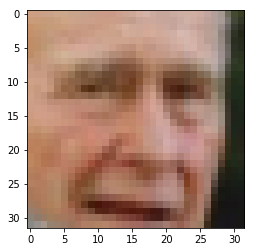

In [91]:
show_image(X[6])

In [92]:
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [93]:
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [94]:
IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 64)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 64)                196672    
_________________________________________________________________
sequential_4 (Sequential)    (None, 32, 32, 3)         199680    
Total params: 396,352
Trainable params: 396,352
Non-trainable params: 0
_________________________________________________________________
None


In [95]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20,
                validation_data=[X_test, X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/20
11828/11828 [==============================] - 8s 650us/step - loss: 0.0108 - val_loss: 0.0069
Epoch 2/20
11828/11828 [==============================] - 4s 354us/step - loss: 0.0060 - val_loss: 0.0054
Epoch 3/20
11828/11828 [==============================] - 4s 327us/step - loss: 0.0051 - val_loss: 0.0048
Epoch 4/20
11828/11828 [==============================] - 5s 382us/step - loss: 0.0048 - val_loss: 0.0046
Epoch 5/20
11828/11828 [==============================] - 4s 328us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 6/20
11828/11828 [==============================] - 4s 325us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 7/20
11828/11828 [==============================] - 4s 331us/step - loss: 0.0046 - val_loss: 0.0047
Epoch 8/20
11828/11828 [==============================] - 4s 348us/step - loss: 0.0046 - val_loss: 0.0046
Epoch 9/20
11828/11828 [==============================] - 4s 325us/step - loss: 0.0046 - val_loss: 0.00

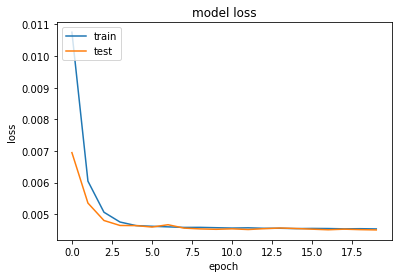

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
def imshow_autoencoder(example_image):
    z = encoder.predict(np.array([example_image]))
    reconstructed = decoder.predict(z)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    ax1.imshow(np.clip(example_image + 0.5, 0, 1))
    ax1.axis('off')
    ax1.set_title('Input Image')

    ax2.imshow(z.T)
    ax2.axis('off')
    ax2.set_title('Latent Representation')

    ax3.imshow(np.clip(reconstructed[0] + 0.5, 0, 1))
    ax3.axis('off')
    ax3.set_title('Reconstruction')

    plt.show()

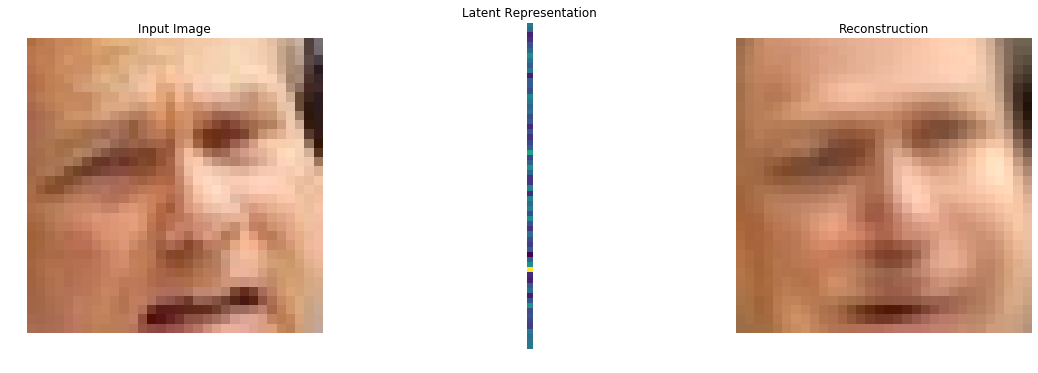

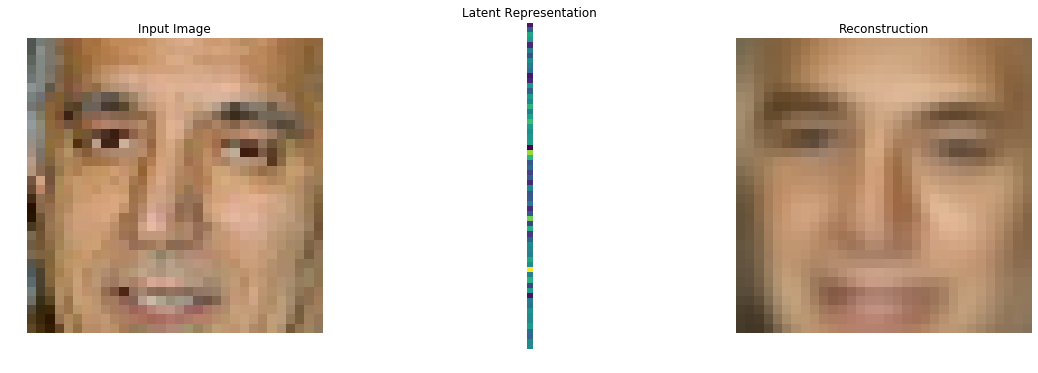

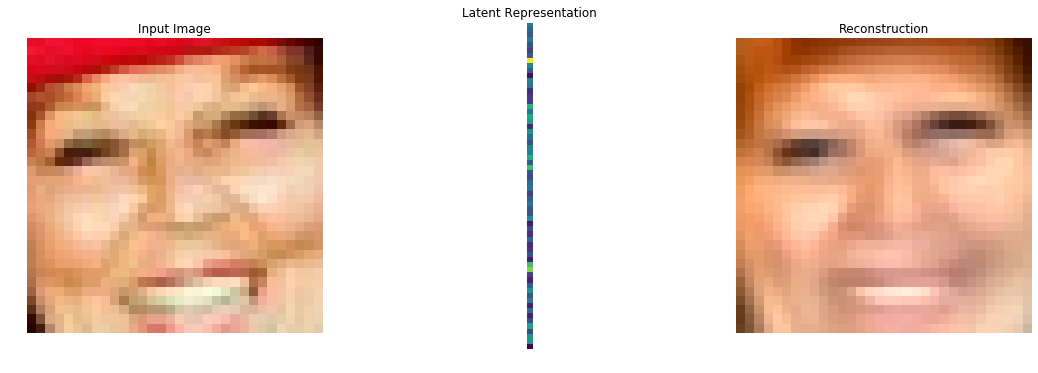

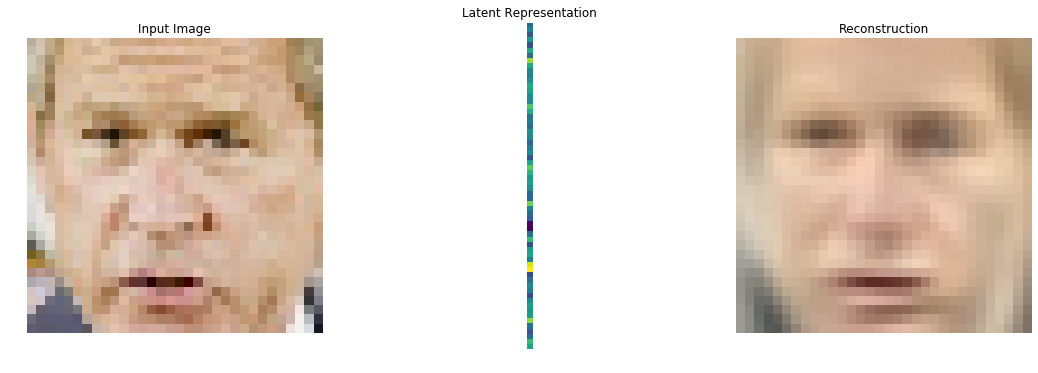

In [98]:
random.seed(0)
imshow_autoencoder(random.choice(X))
imshow_autoencoder(random.choice(X))
imshow_autoencoder(random.choice(X))
imshow_autoencoder(random.choice(X))